Duration: 2.00 seconds
Sample rate: 12000 Hz
Audio files found: 10
Spectrogram files found: 0
To process: 10
0


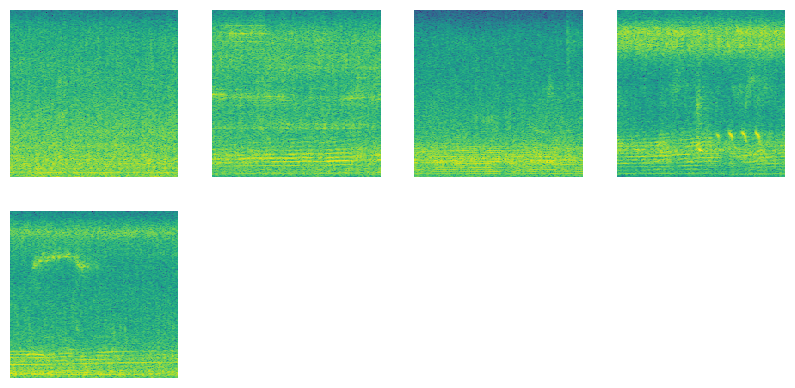

In [1]:
# example usage of audio data preprocessing

from tfk_audio import preprocess

# load a single file, and check audio duration and sample rate
wav, sr = preprocess.audio.load_wav("data/wav/chainsaw/1.wav", print_audio_info=True)

# create a spectrogram generator
specgen = preprocess.spec.SpecGenerator(
    sample_rate=sr,
    stft_window_seconds=0.05,
    stft_hop_seconds=0.01,
    db_limits=(None, None),
    sample_seconds=2.0
)
spec = specgen.wav_to_spec(wav)

# process all .wav files in a folder
specgen.process_folder(indir="data/wav", outdir="data/spectrogram", limit=None)

# check examples for a specific class
specgen.plot_examples(path="data/spectrogram/chainsaw")

# save and load spectrogram generator parameters
specgen.to_json("data/demo_specgen.json")
specgen.from_json("data/demo_specgen.json")


Creating tfrecord files in data/tfrecords/
0
Spectrogram batch shape: (10, 196, 513)
Label batch shape: (10, 2)


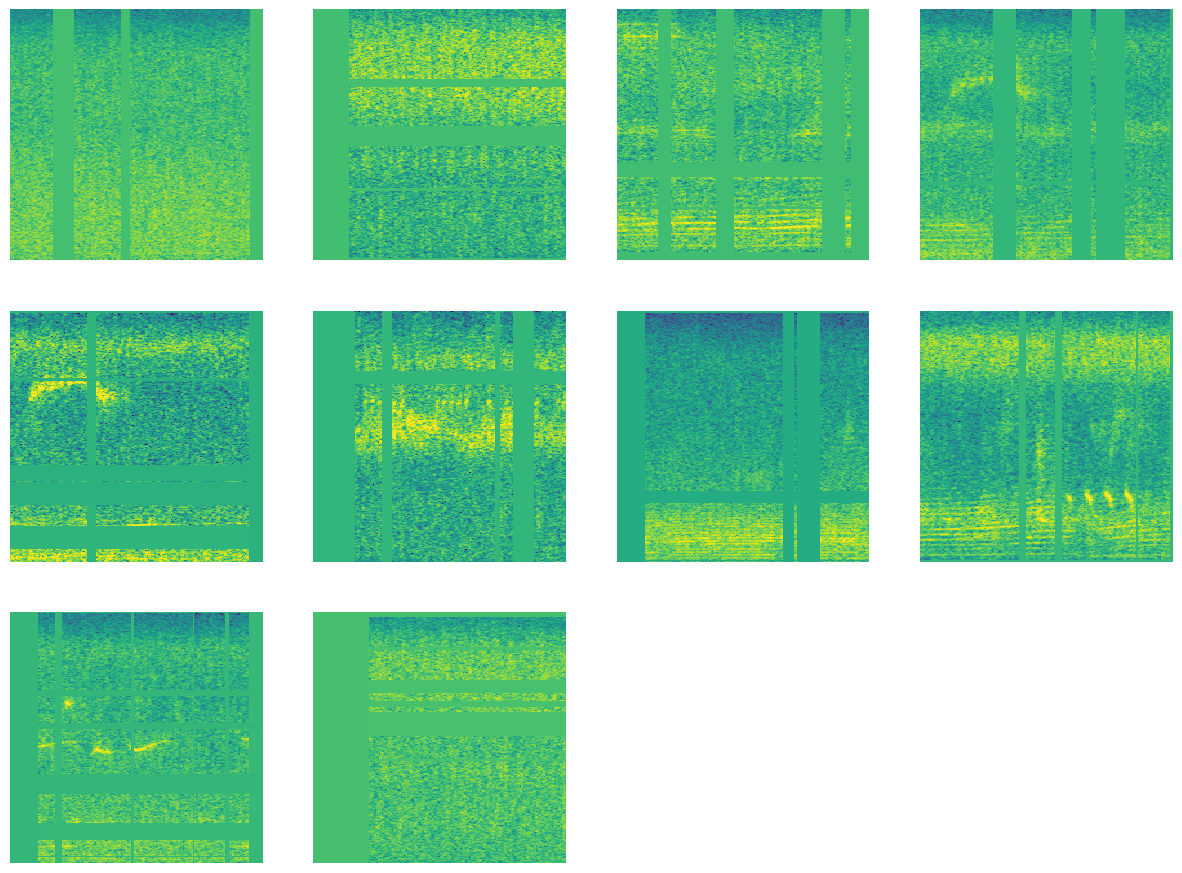

In [2]:
# example usage of the data generator

from tfk_audio.fit import datagen, labels

# get list of spectrogram file paths and label map
# also supports creating dataset partitions and resampling classes
files_train, _, _, label_map = datagen.get_files_and_label_map("data/spectrogram/")

# get labels based on file list
# supports various label formats
labels_train = labels.get_classification_labels(
    files=files_train, 
    label_map=label_map,
    label_format='multi-class-one-hot'
)

# save the spectrograms and labels as TFRecord files
tfrecord_files = datagen.create_tfrecords(
    files=files_train,
    labels=labels_train,
    outdir="data/tfrecords/",
    batch_size=10,
    overwrite=True
)

# load the TFRecord files into a dataset
dataset = datagen.spectrogram_dataset_from_tfrecords(
    files=tfrecord_files,
    image_shape=specgen.image_shape,
    nclass=len(label_map),
    batch_size=10,
    augment=True,  # Enable data augmentation
    label_smoothing=0.1  # apply label smoothing
)

# visualize an augmented batch
for batch in dataset.take(1):
    
    spectrogram_batch, label_batch = batch
    print("Spectrogram batch shape:", spectrogram_batch.shape)
    print("Label batch shape:", label_batch.shape)

    # Plot the spectrograms in the batch
    datagen.plot_batch_samples(spectrogram_batch, nr=4, nc=4, dblims=(-100, 20))
    

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tfk_audio.fit.layers import SpecImageNet, WavImageNet

target_shape = (224, 224)  # height and width of the output image

# choose whether to use WavImageNet or SpecImageNet
use_waveform = False  # Set to False if you want to use spectrogram inputs

if use_waveform:
    # use WavImageNet for waveform inputs
    preprocess_layer = WavImageNet(target_shape=(224, 224), spec_params=specgen.get_config())
    input_shape = (int(specgen.sample_rate * specgen.sample_rate),)
else:
    # use SpecImageNet for spectrogram inputs
    preprocess_layer = SpecImageNet(target_shape=(224, 224))
    input_shape = (None, None, 1)  # Spectrogram input shape

# load a pre-trained ResNet50 model (without the top layer)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# add the preprocessing layer as the head
inputs = tf.keras.Input(shape=input_shape)
x = preprocess_layer(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(label_map), activation='softmax')(x)  # Example: 10 output classes

# create the final model
model = Model(inputs, outputs)

# compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# print the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 spec_to_imagenet (Function  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                             

In [4]:
# testing masked loss/metric

import tensorflow as tf
from tfk_audio.fit.metrics import MaskedMetric, MaskedLoss

masked_loss = MaskedLoss(loss_fn=tf.keras.losses.BinaryCrossentropy(), mask_val=-1.0)
masked_metric = MaskedMetric(metric=tf.keras.metrics.MeanSquaredError(), mask_val=-1.0)

# define masked/unmasked label arrays
y_true_masked =   tf.constant([[1.0, -1.0, 0.0], [0.0, 1.0, -1.0]])
y_true_unmasked = tf.constant([[1.0,  0.0, 0.0], [0.0, 1.0,  0.0]])

# example prediction array
y_pred_incorrect_masked = tf.constant([[0.9,  0.5, 0.1], [0.1, 0.9,  0.5]])
y_pred_correct_unmasked = tf.constant([[0.9,  0.0, 0.1], [0.1, 0.9,  0.0]])

# check that the loss for the masked, incorrect predictions is
# equal to the loss for correct, unmasked predictions
assert (
    masked_loss(
        y_true_masked, 
        y_pred_incorrect_masked
    ) == masked_loss(
        y_true_masked, 
        y_pred_correct_unmasked
    )
), 'Error: losses are not equal'
        